In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
base=automap_base()

# reflect the tables
base.prepare(engine, reflect= True)

In [8]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement= base.classes.measurement
station= base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session= Session(engine)

# Exploratory Climate Analysis

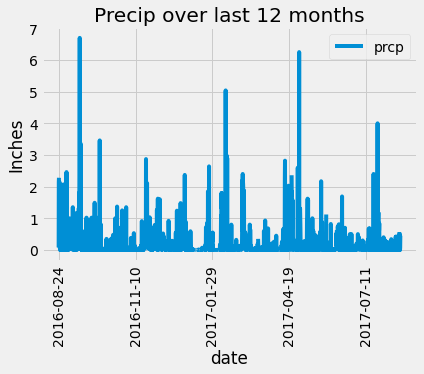

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

year= session.query(measurement).order_by(measurement.date.desc()).limit(1)

for date in year:
    most_recent= date.date
    
most_recent=dt.datetime.strptime(most_recent, "%Y-%m-%d")

#most_recent

# Calculate the date 1 year ago from the last data point in the database

one_year= most_recent- dt.timedelta(days=365)

#one_year

# Perform a query to retrieve the data and precipitation scores
recent_precip= session.query(measurement.date, measurement.prcp). filter(measurement.date >= one_year).order_by(measurement.date).all()

#recent_precip

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df= pd.DataFrame(recent_precip)
#precip_df.head

#Set index to date

date=precip_df.set_index([precip_df['date']])
#date

# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(x="date", y= "prcp")
plt.title("Precip over last 12 months")
plt.xticks(rotation= 90)
plt.ylabel("Inches")
plt.savefig("images/yearprecip.jpg")
plt.show()



In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(measurement.station).distinct().count()

stations

9

In [46]:
# What are the most active stations? (i.e. what stations have the most rows)?
count= (session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all())

count
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = count[0][0]
print(most_active)

#query for highest temperature
highesttemp = (session.query(measurement.tobs).\
               filter(measurement.station == most_active).order_by(measurement.tobs.desc()) .first())
highestTemp = highesttemp[0]
print(highesttemp)

#query for lowest temperature
lowesttemp = (session.query(measurement.tobs).\
              filter(measurement.station == most_active).order_by(measurement.tobs.asc()).first())
lowestemp = lowesttemp[0]
print(lowesttemp)

#query for average temperature
avgtemp = (session.query(func.avg(measurement.tobs)).\
           filter(measurement.station == most_active))
avgtemp = '{0:.3}'.format(avgtemp[0][0])
print(avgtemp)

USC00519281
(85.0,)
(54.0,)
71.7


In [69]:
session.query(func.max(measurement.tobs),func.min(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active).all()


[(85.0, 54.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

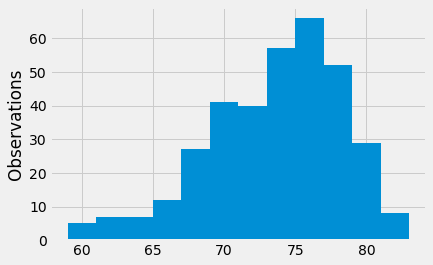

In [62]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_obs= session.query(measurement.tobs).\
                filter(measurement.station== most_active).\
                filter(measurement.date >= one_year). order_by(measurement.date.desc()).all()

x= [x[0] for x in most_obs]

plt.hist(x, bins=12)
plt.ylabel('Observations')
plt.savefig("images/observationtemp.jpeg")
plt.show

## Bonus Challenge Assignment

In [64]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [72]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
min_temp, avg_temp, max_temp= calc_temps('2017-02-14', '2017-02-22')[0]
print(min_temp, avg_temp, max_temp)

65.0 71.79629629629629 79.0


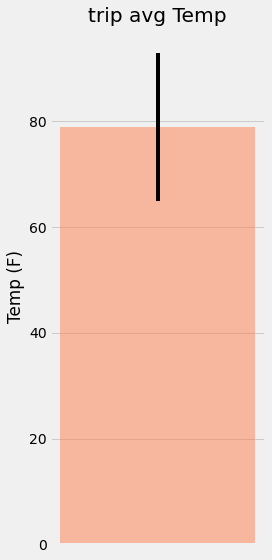

In [76]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr= max_temp- min_temp
fig,ax= plt.subplots(figsize=plt.figaspect(2.))
bar= ax.bar(1,max_temp, yerr=yerr, align= "center", alpha= .5, color= "coral") 
ax.set(xticks= range(1), title= "trip avg Temp", ylabel= "Temp (F)")
plt.savefig("images/vacationtemp.jpeg")
fig.tight_layout()


In [81]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)).\
              filter(measurement.station== station.station).\
              filter(measurement.date >= '2017-02-14').\
              filter(measurement.date <= '2017-02-22').\
              group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()


[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  1.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.87),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.8600000000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.7899999999999999),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.7000000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.19),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.17)]

In [84]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [87]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

start_date= '2017-02-14'
end_date= '2017-02-22'

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

date_range= pd.date_range(start_date, end_date, freq="D")

# Stip off the year and save a list of %m-%d strings

month_day=date_range.strftime('%m-%d')
daily_temp= []

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in month_day:
    daily_temp.append(*daily_normals(date))
daily_temp

[(62.0, 70.89473684210526, 79.0),
 (56.0, 70.28813559322033, 79.0),
 (59.0, 70.48214285714286, 76.0),
 (62.0, 70.47272727272727, 77.0),
 (63.0, 70.79629629629629, 77.0),
 (60.0, 69.33962264150944, 77.0),
 (63.0, 70.14035087719299, 76.0),
 (63.0, 69.79629629629629, 76.0),
 (60.0, 70.15789473684211, 83.0)]

In [91]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_df= pd.DataFrame(daily_temp, columns=['Min', 'Avg', 'Max'])
daily_df['date']= date_range
daily_df.set_index(['date'], inplace= True)
daily_df

,Min,Avg,Max
date,,,
2017-02-14,62.0,70.894737,79.0
2017-02-15,56.0,70.288136,79.0
2017-02-16,59.0,70.482143,76.0
2017-02-17,62.0,70.472727,77.0
2017-02-18,63.0,70.796296,77.0
2017-02-19,60.0,69.339623,77.0
2017-02-20,63.0,70.140351,76.0
2017-02-21,63.0,69.796296,76.0
2017-02-22,60.0,70.157895,83.0


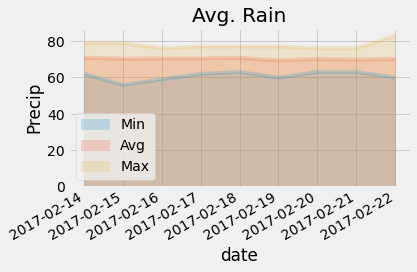

In [98]:
# Plot the daily normals as an area plot with `stacked=False`
daily_df.plot(kind='area', stacked= False, x_compat=True, alpha= .2)
plt.ylabel('Precip')
plt.title('Avg. Rain')
plt.savefig("images/vacationprec.jpeg")

plt.tight_layout()